## Kaggle's Credit Card Fraud Dataset -  (IMBALANCED DATASET)

The data is from: https://www.kaggle.com/mlg-ulb/creditcardfraud

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<b>Context</b><br>
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Reference: Machine Learning Course (Professor S.R Das, Santa Clara University)

In [22]:
%pylab inline
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#import os
#from ipypublish import nb_setup
#%load_ext rpy2.ipython

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Read the data file
cc = pd.read_csv("DSTMAA_data/creditcard.csv")

<b>Data Exploration

There are 28 anonymized variables (V1 to V28) in the data set. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we did not have the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [5]:
cc.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


Total number of observations

In [6]:
cc.shape

(284807, 31)

Total number of Fradulent Transactions (1)

In [28]:
cc.Class.sum()

492

Percentage of fradulent transactions in the data. <b>Data is highly imbalanced.<b>

In [7]:
cc.Class.mean()*100

0.1727485630620034

'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. <br>In one day we have 24x60x60 = 86,400 seconds. Therefore, in two days we have 172800 seconds. <br><br> Assuming time starts at midnight of first day, then we can see that in the morning at 8:30 AM number of transactions picked up (i.e. after 8.33 hours or 30,000 seconds later). It is just showing the elapsed time. nothing much. We will drop this variable.  

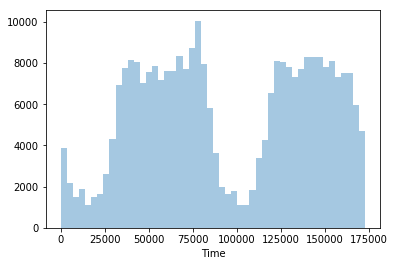

In [12]:
sns.distplot(cc.Time, kde=False)

Amount is the only variable which is remaining. It is important variable as fradulent transaction normally don't follow the regular pattern. Also, this variable is not used in PCA transformation. Exploring amount variable.

In [13]:
cc.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

The above summary indicates the possibility of outliers as 75 percentile of the amount is around 77 dollars but maximum amount is 25,691 dollars (Huge gap). <br>Also, plotting histogram to see this visually. Below histogram indicates there are very few transactions at the higher amounts. 

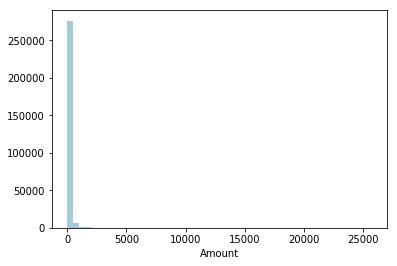

In [14]:
sns.distplot(cc.Amount, kde=False)

There are only 7 transactions which are greater than 10,000 dollars and all of these transactions are non-fradulent (Class 0). Therefore, removing these outliers.

In [17]:
cc[cc.Amount>10000]
cc = cc[cc.Amount<10000]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
46841,42951.0,-23.712839,-42.172688,-13.320825,9.925019,-13.945538,5.564891,15.710644,-2.844253,-1.580725,...,7.921600,-6.320710,-11.310338,0.404175,-4.547278,-1.577118,-2.357385,2.253662,12910.93,0
54018,46253.0,-21.780665,-38.305310,-12.122469,9.752791,-12.880794,4.256017,14.785051,-2.818253,-0.667338,...,7.437478,-5.619439,-10.547038,0.653249,-4.232409,-0.480459,-2.257913,2.082488,11898.09,0
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0
169457,119713.0,-20.924897,-37.943452,-14.060281,10.473005,-10.866639,6.256654,14.960521,-2.392155,-0.597076,...,6.829810,-6.926353,-9.928657,-0.447084,-4.848151,-2.241620,-2.140723,2.001492,11789.84,0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,...,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0


Normalizing the amount variable

In [18]:
cc['amt_normalized'] = ((cc.Amount) - (cc.Amount.mean()))/(cc.Amount.std())

<b>Create training (67% of the data) and test (33%) data sets. 

In [20]:
y = cc.Class
X = cc.drop(columns =['Class','Amount','Time'])

In [23]:
#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

<b> Using logistic regression classifier to the training data. 

In [30]:
# instantiate a logistic regression model, and fit with X_train and y_train
model = LogisticRegression()
model = model.fit(X_train, y_train)

# check the accuracy on the training set
model.score(X_train, y_train)

# Predict class labels for the test set
predicted = model.predict(X_train)

# Confusion Matrix for train data
print(confusion_matrix(predicted, y_train))

0.9992348609910122

[[190464    121]
 [    25    205]]


Confusion Matrix for <b>test</b> dataset

In [31]:
# check the accuracy on the test dataset
model.score(X_test, y_test)

# Predict class labels for the test dataset
predicted = model.predict(X_test)

# Confusion Matrix for test data
print(confusion_matrix(predicted, y_test))

0.9991275110657133

[[93799    63]
 [   19   103]]


<b>A. Percision = $\frac{TP}{TP+FP}$
    <br>B. Recall = $\frac{TP}{TP+FN}$
    <br>C. F1 score = $\frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$

In [32]:
print(classification_report(predicted, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93862
           1       0.62      0.84      0.72       122

   micro avg       1.00      1.00      1.00     93984
   macro avg       0.81      0.92      0.86     93984
weighted avg       1.00      1.00      1.00     93984



Text(0.5,1,'ROC curve')

Text(0.5,0,'FPR (Precision)')

Text(0,0.5,'TPR (Recall)')

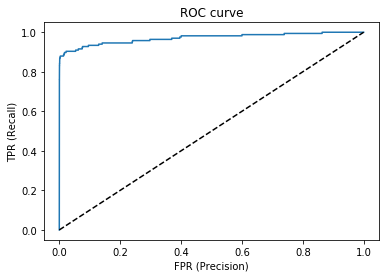

Area under curve (AUC):  0.9705905846413216


In [33]:
#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

This is highly imbalanced dataset. Because of which we are getting very high accuracy score and AUC scores.<br> Confusion matrix shows us that our model is predicting non-fradulent transactions more efficiently than the fradulent transactions (F1 score for non-fradulent transactions is 100% whereas for fradulent transactions it is 72%). <br>One reason for this is - We have 99.9% of non-fradulent transactions and only 0.172% of fradulent transactions.

Objective is to correctly identify the fradulent transactions. We cannot afford to mispredict so many fradulent transactions. The model is able to predict only 62% of fraudulent transactions (precision score).

<b> In order to treat imbalanced dataset, we will use oversampling method (SMOTE) to generate similar records of minority class (i.e. fradulent transactions in this dataset).

<b><i>Informed Oversampling - Synthetic Minority Over-sampling Technique (SMOTE)

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=0)

# instantiate a logistic regression model, and fit with X_train and y_train
model = LogisticRegression()
model = model.fit(X_res, y_res)

In [38]:
# check the accuracy on the test dataset
model.score(X_test, y_test)

# Predict class labels for the test dataset
predicted = model.predict(X_test)

# Confusion Matrix for test data
print(confusion_matrix(predicted, y_test))

print(classification_report(predicted, y_test))

0.9563246184071331

[[61379  3885]
 [ 1606 58853]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     65264
           1       0.94      0.97      0.96     60459

   micro avg       0.96      0.96      0.96    125723
   macro avg       0.96      0.96      0.96    125723
weighted avg       0.96      0.96      0.96    125723



Text(0.5,1,'ROC curve')

Text(0.5,0,'FPR (Precision)')

Text(0,0.5,'TPR (Recall)')

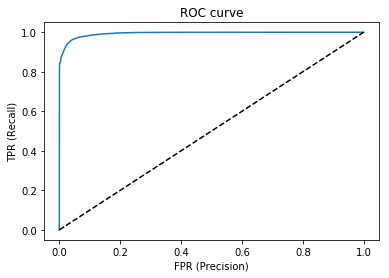

Area under curve (AUC):  0.9938563499135517


In [39]:
#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b>After doing SMOTE (Oversampling), our AUC, precision, recall & F1 scores have increased to 99.3%, 94%, 97% & 96% respectively. 

------------------------------ End of document ------------------------------ 